In [1]:
import numpy as np
import tensorflow as tf
from os import listdir
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras_preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import os
import cv2 as cv
# import pickle
# import sklearn
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/train",
    shuffle=True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 18345 files belonging to 10 classes.


In [3]:
dataset_valid = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/valid",
    shuffle=True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4585 files belonging to 10 classes.


In [4]:
class_names = dataset_valid.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites',
 'Target_Spot',
 'Yellow_Leaf_Curl_Virus',
 'healthy',
 'mosaic_virus']

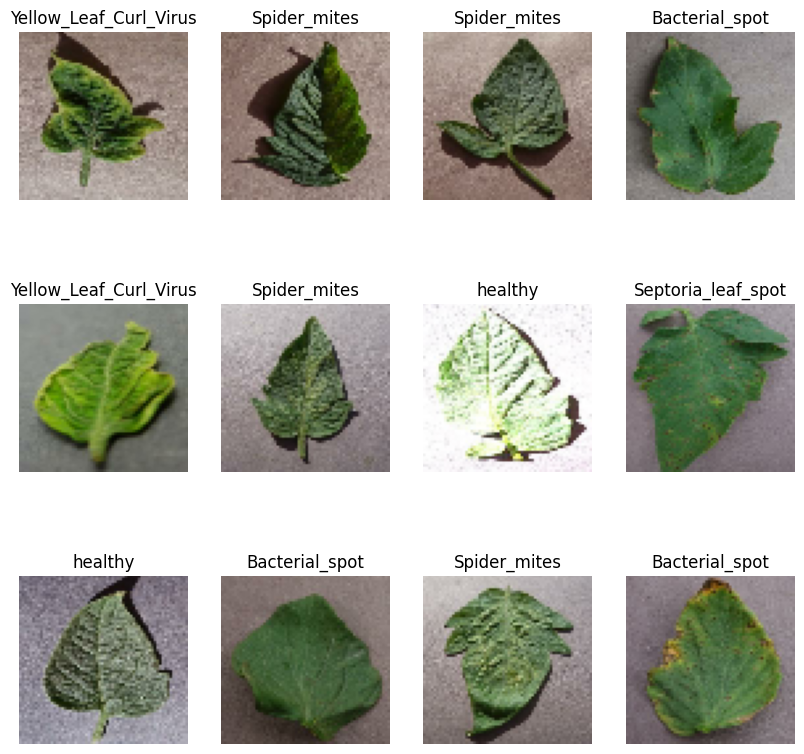

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset_train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [6]:
def get_dataset(dataset_train, dataset_valid, val_split=0.5, test_split = 0.5, shuffle = True, shuffle_size=10000):
    ds_size = len(dataset_valid)
    if shuffle:
        dataset_train = dataset_train.shuffle(shuffle_size, seed= 12)
        dataset_valid = dataset_valid.shuffle(shuffle_size, seed= 12)
    
    val_size = int(val_split*ds_size)
    val_ds=dataset_valid.take(val_size)
    test_ds = dataset_valid.skip(val_size)
    return dataset_train, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset(dataset_train, dataset_valid)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
n_classes = 10
model = Sequential()
inputShape = (64, 64, 3)
chanDim = -1
if K.image_data_format()=="channels_first":
    inputShape=(depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=inputShape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation('relu'))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)       

In [13]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
hist = model.fit(train_ds,
                 epochs = 50,
                 batch_size = BATCH_SIZE,
                 verbose = 1,
                 validation_data=valid_ds)

Epoch 1/50
574/574 [==============================] - 544s 911ms/step - loss: 4.1487 - accuracy: 0.1687 - val_loss: 3.2829 - val_accuracy: 0.1749
Epoch 2/50
574/574 [==============================] - 402s 700ms/step - loss: 2.9494 - accuracy: 0.1471 - val_loss: 2.6728 - val_accuracy: 0.1398
Epoch 3/50
574/574 [==============================] - 384s 669ms/step - loss: 2.7024 - accuracy: 0.1197 - val_loss: 2.6645 - val_accuracy: 0.1172
Epoch 4/50
574/574 [==============================] - 394s 687ms/step - loss: 2.7333 - accuracy: 0.1280 - val_loss: 2.3643 - val_accuracy: 0.0968
Epoch 5/50
574/574 [==============================] - 392s 684ms/step - loss: 2.5376 - accuracy: 0.1127 - val_loss: 2.8470 - val_accuracy: 0.1146
Epoch 6/50
574/574 [==============================] - 265s 461ms/step - loss: 2.4182 - accuracy: 0.1124 - val_loss: 2.4677 - val_accuracy: 0.0990
Epoch 7/50
574/574 [==============================] - 334s 583ms/step - loss: 2.3764 - accuracy: 0.1006 - val_loss: 2.3445 -